In [13]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [14]:
data=pd.read_csv("train.csv")
data.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [9]:
import pandas_profiling as pp

In [10]:
pp.ProfileReport(data)

# Preprocessing

In [15]:
#drop cols with too many missing values(cabin), drop cols not related to y by domain knowledge (id, name, ticket)
data.drop(["PassengerId","Cabin","Name","Ticket"],inplace=True,axis=1)

In [17]:
#Age: 177 missing values, fill by mean (?)
#note: delete if only less than 10 missing values
data["Age"]=data["Age"].fillna(data["Age"].mean())
data=data.dropna()

## Categorical into numerical

In [19]:
#binary into numerical
data["Sex"] = (data["Sex"]=="male").astype("int")

#trinity into numerical
labels = data["Embarked"].unique().tolist()
data["Embarked"]=data["Embarked"].apply(lambda x: labels.index(x))

/Users/zhinan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/zhinan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
data.head()

Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500         0
1         1       1    0  38.0      1      0  71.2833         1
2         1       3    0  26.0      0      0   7.9250         0
3         1       1    0  35.0      1      0  53.1000         0
4         0       3    1  35.0      0      0   8.0500         0

# Splitting Traning & Testing Sets

In [22]:
X = data.iloc[:,data.columns!= "Survived"]
y = data.iloc[:,data.columns == "Survived"]

from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y,test_size=0.3)

#correct index for testing/training sets
for i in [Xtrain, Xtest, Ytrain, Ytest]:
    i.index = range(i.shape[0])
    
Xtrain.head()

Pclass  Sex        Age  SibSp  Parch     Fare  Embarked
0       3    1  39.000000      1      5  31.2750         0
1       3    1  29.699118      0      0   8.0500         0
2       3    1  29.699118      0      0   7.2292         1
3       3    1  24.500000      0      0   8.0500         0
4       2    1  29.699118      0      0   0.0000         0

# apply model, initial outcomes

In [23]:
clf = DecisionTreeClassifier(random_state=25)
clf = clf.fit(Xtrain, Ytrain)
score_ = clf.score(Xtest,Ytest)
score_

0.8052434456928839

In [24]:
score = cross_val_score(clf,X,y,cv=10).mean()
score

0.7739274770173645

# different max_depth outcomes

0.8177860061287026


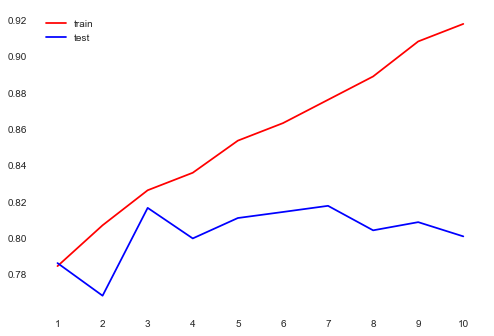

In [25]:
tr = []
te = []
for i in range (10):
    clf = DecisionTreeClassifier(random_state=25
                                ,max_depth=i+1
                                ,criterion="entropy")
    clf = clf.fit(Xtrain,Ytrain)
    score_tr=clf.score(Xtrain,Ytrain)
    score_te=cross_val_score(clf,X,y,cv=10).mean()
    tr.append(score_tr)
    te.append(score_te)
print(max(te))

plt.plot(range(1,11),tr,color="red",label = "train")
plt.plot(range(1,11),te,color="blue",label = "test")
plt.xticks(range(1,11))
plt.legend()
plt.show()

# Find better parameters with Grid Search

In [26]:
import numpy as np
gini_thresholds = np.linspace(0,0.5,20)

parameters = {'splitter':('best','random')
             ,'criterion':('gini','entropy')
             ,'max_depth':[*range(1,50,5)]
             ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }

clf = DecisionTreeClassifier(random_state=25)
GS = GridSearchCV(clf,parameters,cv=10)
GS.fit(Xtrain,Ytrain)
GS.best_params_

/Users/zhinan/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'criterion': 'gini',
 'max_depth': 6,
 'min_impurity_decrease': 0.0,
 'splitter': 'best'}

In [27]:
GS.best_score_

0.815112540192926